<a href="https://colab.research.google.com/github/Pavan0325/Applied/blob/main/Pavan%2C_Stock_Market_Prediction_and_Financial_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

**Extracting Data for Tesla from Yahoo API**

In [ ]:
ticker_symbol = 'TSLA'


data = yf.download(ticker_symbol, start='2010-01-01', end='2024-06-10')

data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


**Performing Data Preprocessing Operations and Visualization**

In [ ]:
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [ ]:
data['Close'] = scaled_data

In [ ]:
data = data[['Close']]

# Convert the dataframe to a numpy array
dataset = data.values

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

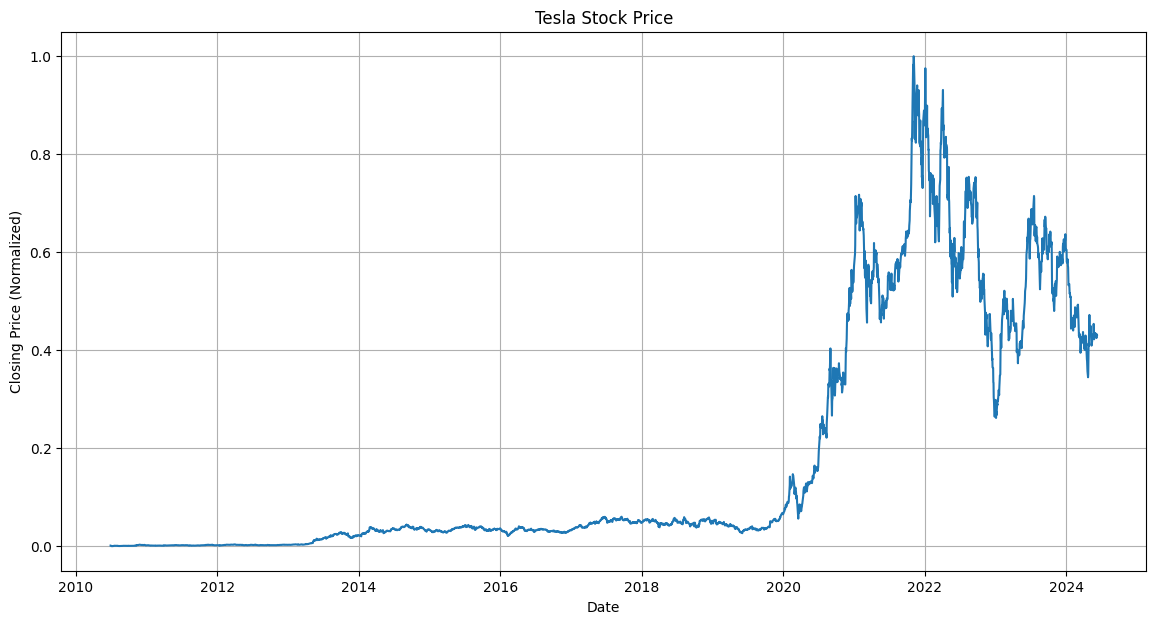

In [ ]:
plt.figure(figsize=(14, 7))
plt.title('Tesla Stock Price')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price (Normalized)')
plt.grid(True)
plt.show()

**Buidling LSTM Acrhitecture and Training model**

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 60

# Create sequences for training data
X_train, y_train = create_sequences(train_data, seq_length)

# Create sequences for testing data
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
model = Sequential()

# Add LSTM layer with 50 units, input shape (seq_length, 1)
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))

# Add LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add Dense layer with 1 unit (output layer)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
86/86 [==============================] - 11s 56ms/step - loss: 0.0022
Epoch 2/20
86/86 [==============================] - 5s 53ms/step - loss: 5.4505e-04
Epoch 3/20
86/86 [==============================] - 7s 85ms/step - loss: 4.9187e-04
Epoch 4/20
86/86 [==============================] - 6s 65ms/step - loss: 4.3966e-04
Epoch 5/20
86/86 [==============================] - 8s 93ms/step - loss: 3.7998e-04
Epoch 6/20
86/86 [==============================] - 5s 63ms/step - loss: 3.7464e-04
Epoch 7/20
86/86 [==============================] - 6s 74ms/step - loss: 3.6385e-04
Epoch 8/20
86/86 [==============================] - 6s 72ms/step - loss: 4.2481e-04
Epoch 9/20
86/86 [==============================] - 5s 59ms/step - loss: 3.3889e-04
Epoch 10/20
86/86 [==============================] - 7s 87ms/step - loss: 3.8904e-04
Epoch 11/20
86/86 [==============================] - 5s 64ms/step - loss: 4.1417e-04
Epoch 12/20
86/86 [==============================] - 7s 86ms/step - loss: 3.2

**Evaluating Model Performance**

In [ ]:
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))

# Inverse transform original training data for comparison
train_true = scaler.inverse_transform(y_train.reshape(-1, 1))

# Calculate MSE for training data
train_mse = mean_squared_error(train_true, train_predictions)
print(f"Training Mean Squared Error (MSE): {train_mse}")

# Evaluate the model on testing data
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))

# Inverse transform original testing data for comparison
test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE for testing data
test_mse = mean_squared_error(test_true, test_predictions)
print(f"Testing Mean Squared Error (MSE): {test_mse}")

86/86 [==============================] - 5s 38ms/step
Training Mean Squared Error (MSE): 0.00011416130888296931
21/21 [==============================] - 0s 18ms/step
Testing Mean Squared Error (MSE): 0.0016842420792559445


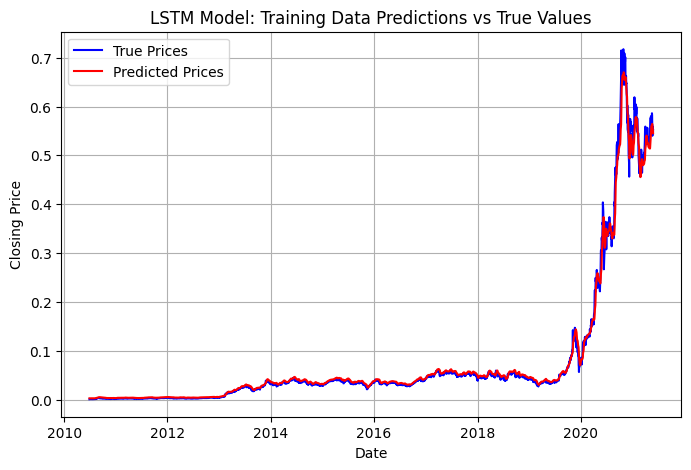

In [ ]:
plt.figure(figsize=(8, 5))
plt.title('LSTM Model: Training Data Predictions vs True Values')
plt.plot(data.index[:len(train_true)], train_true, label='True Prices', color='blue')
plt.plot(data.index[:len(train_predictions)], train_predictions, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

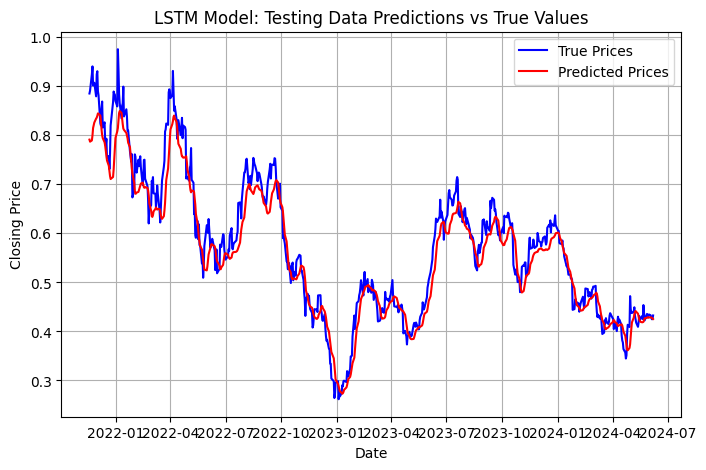

In [ ]:
plt.figure(figsize=(8, 5))
plt.title('LSTM Model: Testing Data Predictions vs True Values')
plt.plot(data.index[-len(test_true):], test_true, label='True Prices', color='blue')
plt.plot(data.index[-len(test_predictions):], test_predictions, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()